## Load Packages

In [15]:
! pip install catboost

In [81]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import os
import re
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## NLTK imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# gensim imports
from gensim import corpora
from gensim.models import LdaModel


## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, r2_score, jaccard_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# catboost imports
from catboost import CatBoostRegressor

# LightGBM imports
import lightgbm as lgb
from lightgbm import *

## Miscellaneous imports
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist, squareform
from textblob import TextBlob
import shap
from wordcloud import WordCloud
import random
import statsmodels.api as sm

## Transformers and sentence embedding imports
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments

## Spacy imports
import spacy
from spacy.lang.en import STOP_WORDS

# IPython settings for interactive shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from google.colab import drive

from scipy.stats import ttest_ind, f_oneway

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load Tweet Data

In [17]:
DT_tweet_df = pd.read_csv('/content/drive/MyDrive/QSS_45/realdonaldtrump.csv')

DT_tweet_df_2 = pd.read_csv('/content/drive/MyDrive/QSS_45/trumptweets.csv')

DT_tweet_df_3 = pd.read_csv('/content/drive/MyDrive/QSS_45/trump_tweets_3.csv')

## Prepare Tweet Data

In [18]:
min_date = DT_tweet_df['date'].min()
max_date = DT_tweet_df['date'].max()

# print("Minimum Date:", min_date)
# print("Maximum Date:", max_date)

min_date_2 = DT_tweet_df_2['date'].min()
max_date_2 = DT_tweet_df_2['date'].max()

# print("Minimum Date:", min_date_2)
# print("Maximum Date:", max_date_2)

min_date_3 = DT_tweet_df_3['date'].min()
max_date_3 = DT_tweet_df_3['date'].max()

# print("Minimum Date:", min_date_3)
# print("Maximum Date:", max_date_3)

In [19]:
DT_tweet_df_3.columns = ['id', 'content', 'is_retweeted', 'is_deleted', 'device', 'favorites', 'retweets', 'date', 'is_flagged']

In [20]:
DT_tweet_df = DT_tweet_df[["id", "content", "date", "retweets", "favorites"]]

DT_tweet_df_2 = DT_tweet_df_2[["id", "content", "date", "retweets", "favorites"]]

DT_tweet_df_3 = DT_tweet_df_3[["id", "content", "date", "retweets", "favorites"]]

In [21]:
trump_merged_df = pd.concat([DT_tweet_df, DT_tweet_df_2, DT_tweet_df_3], ignore_index=True)

trump_all_df = trump_merged_df.drop_duplicates(subset=['content'])

In [22]:
trump_all_df['new_id'] = range(1, len(trump_all_df) + 1)

trump_all_df = trump_all_df.drop(columns=['id'])

cols = ['new_id'] + [col for col in trump_all_df if col != 'new_id']
trump_all_df = trump_all_df[cols]

<ipython-input-22-7a4aa3d3a2ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_all_df['new_id'] = range(1, len(trump_all_df) + 1)


In [34]:
# Define a custom function to clean tweets
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove specific words
    custom_stopwords = ["trump", "twitter", "https", "donald", "com", "realdonaldtrump", "amp", "rt"]
    all_stopwords = set(stopwords.words("english")).union(custom_stopwords)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in all_stopwords])
    return text

In [35]:
# Apply cleaning to each tweet
trump_all_df['cleaned_content'] = trump_all_df['content'].apply(clean_text)

In [27]:
trump_all_df['date'] = pd.to_datetime(trump_all_df['date'], errors='coerce')

In [28]:
trump_all_df.to_csv('trump_all_df.csv', index=False, header=True, sep=',')


## EDA

### Sentiment Analysis

<ipython-input-29-58502778dbcd>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_time_series = trump_all_df.resample('M', on='date')['sentiment'].mean()


Text(0.5, 1.0, 'Trump Tweets Sentiment Over Time')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Sentiment')

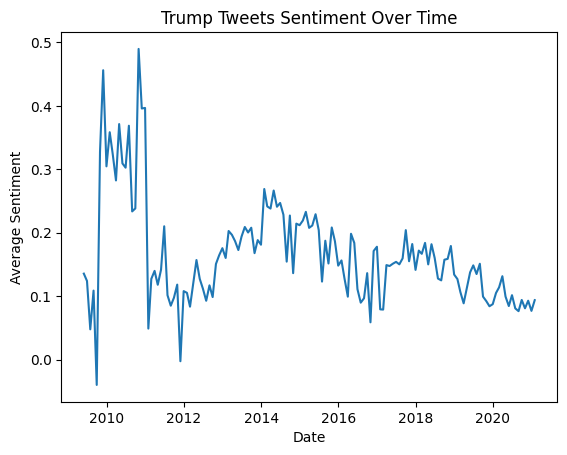

In [29]:
# Sentiment analysis and plotting over time

trump_all_df['sentiment'] = trump_all_df['cleaned_content'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
trump_all_df['date'] = pd.to_datetime(trump_all_df['date'])

# Resample by month and calculate the average sentiment
sentiment_time_series = trump_all_df.resample('M', on='date')['sentiment'].mean()

# Plot sentiment over time
plt.plot(sentiment_time_series)
plt.title('Trump Tweets Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()


Peaks (High Sentiment):
          Date  Sentiment
6   2009-11-30   0.456061
17  2010-10-31   0.489646
25  2011-06-30   0.210068
56  2014-01-31   0.268830
100 2017-09-30   0.204006

Lows (Low Sentiment):
         Date  Sentiment
4  2009-09-30  -0.040000
15 2010-08-31   0.233496
20 2011-01-31   0.048810
30 2011-11-30  -0.002651
89 2016-10-31   0.058694


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Trump Tweets Sentiment Over Time with Peaks and Lows')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Sentiment')

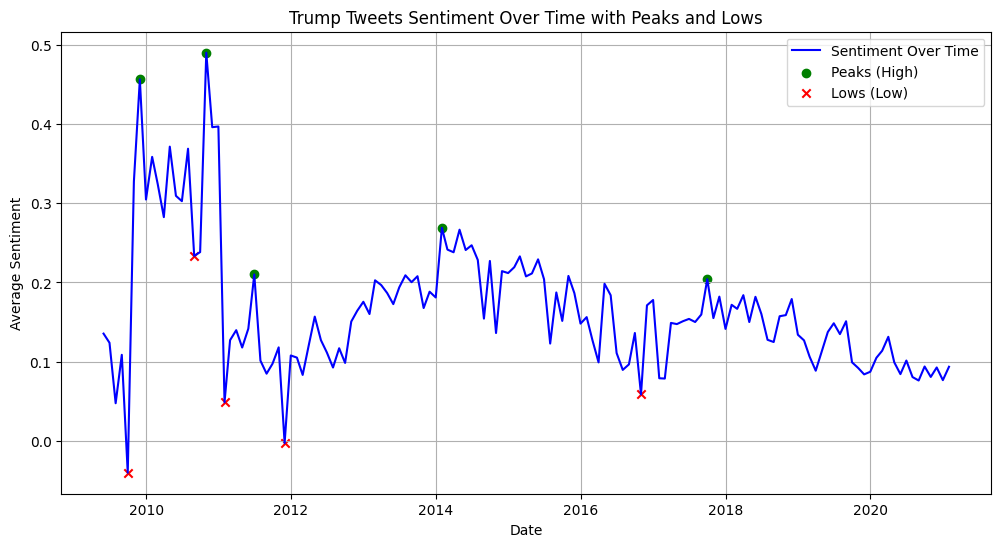

In [30]:
# Find peaks and lows in sentiment
sentiments = sentiment_time_series.values
dates = sentiment_time_series.index

# Detect peaks (positive sentiment spikes)
positive_peaks, _ = find_peaks(sentiments, prominence=0.1)  # Adjust prominence as needed

# Detect lows (negative sentiment dips by inverting the values)
negative_peaks, _ = find_peaks(-sentiments, prominence=0.1)  # Adjust prominence as needed

# Create a DataFrame for easier inspection
peaks_lows_df = pd.DataFrame({
    'Date': dates,
    'Sentiment': sentiments
})

peaks_df = peaks_lows_df.iloc[positive_peaks]
lows_df = peaks_lows_df.iloc[negative_peaks]

print("Peaks (High Sentiment):")
print(peaks_df)

print("\nLows (Low Sentiment):")
print(lows_df)

# Plot with identified peaks and lows
plt.figure(figsize=(12, 6))
plt.plot(dates, sentiments, label='Sentiment Over Time', color='blue')
plt.scatter(peaks_df['Date'], peaks_df['Sentiment'], color='green', label='Peaks (High)', marker='o')
plt.scatter(lows_df['Date'], lows_df['Sentiment'], color='red', label='Lows (Low)', marker='x')
plt.title('Trump Tweets Sentiment Over Time with Peaks and Lows')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()
plt.grid()
plt.show()


In [31]:
# Define the peak and low sentiment scores
peak_sentiments = [0.456061, 0.489646, 0.210068, 0.268830, 0.204006]
low_sentiments = [-0.040000, 0.233496, 0.048810, -0.002651, 0.058694]

# Define a tolerance level for filtering (optional, to capture close matches)
tolerance = 0.001

# Filter for tweets with sentiment scores near the peaks
peak_tweets = trump_all_df[trump_all_df['sentiment'].apply(lambda x: any(abs(x - ps) <= tolerance for ps in peak_sentiments))]

# Filter for tweets with sentiment scores near the lows
low_tweets = trump_all_df[trump_all_df['sentiment'].apply(lambda x: any(abs(x - ls) <= tolerance for ls in low_sentiments))]

# Combine and sort (optional)
combined_tweets = pd.concat([peak_tweets, low_tweets]).sort_values(by='sentiment', ascending=False)

# Display the results
#print("Peak Tweets:")
#print(peak_tweets)
#print("\nLow Tweets:")
#print(low_tweets)


In [32]:
# Function to extract top N-grams
def extract_ngrams(tweets, n=3, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(tweets)
    ngram_counts = ngrams.sum(axis=0).tolist()[0]
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = sorted(zip(ngram_features, ngram_counts), key=lambda x: x[1], reverse=True)
    return ngram_freq[:top_n]

# Analyze Peaks
peak_phrases = extract_ngrams(peak_tweets['cleaned_content'], n=3, top_n=10)
print("Top Repeated Phrases in Peak Tweets:")
for phrase, count in peak_phrases:
    print(f"{phrase}: {count}")

# Analyze Lows
low_phrases = extract_ngrams(low_tweets['cleaned_content'], n=3, top_n=10)
print("\nTop Repeated Phrases in Low Tweets:")
for phrase, count in low_phrases:
    print(f"{phrase}: {count}")


Top Repeated Phrases in Peak Tweets:
hard good luck: 10
work hard good: 10
congress strong crime: 4
new york times: 4
strong crime border: 4
art deal high: 3
barack hussein obama: 3
beginning new year: 3
book read art: 3
buddhists sikhs jains: 3

Top Repeated Phrases in Low Tweets:
fake news media: 8
make america great: 8
25k views signing: 6
books weeks order: 6
great live signing: 6
live signing nite: 6
loves military vets: 6
nite 25k views: 6
order holiday gifts: 6
signing books weeks: 6


### Using LDA for Topic Modeling

LatentDirichletAllocation(n_components=7, random_state=42)

<Axes: xlabel='month'>

Text(0.5, 1.0, 'Trump Tweet Topics Over Time')

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Month')

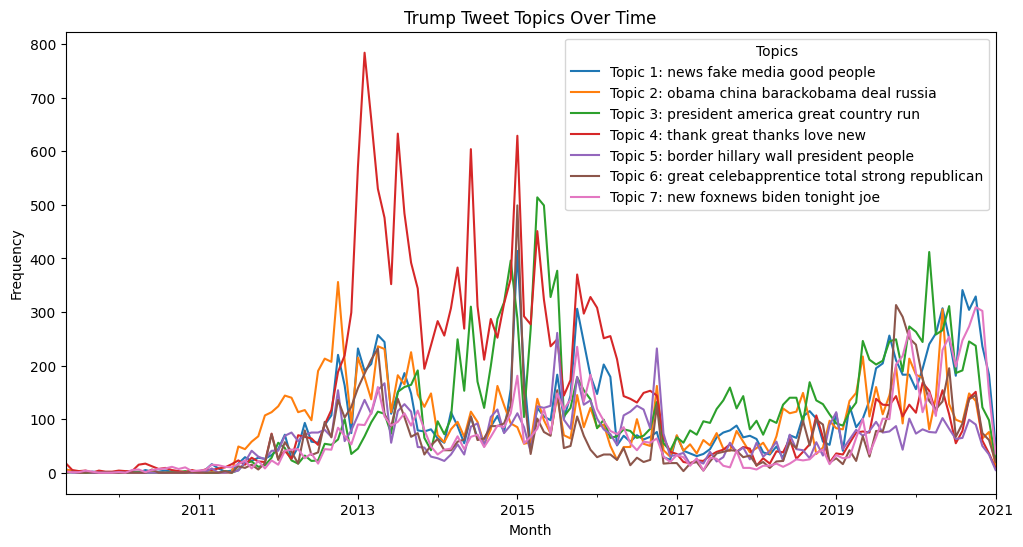

In [36]:
# Vectorize the tweet text
vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             stop_words='english')
X = vectorizer.fit_transform(trump_all_df['cleaned_content'])

# Apply LDA to find topics
lda = LatentDirichletAllocation(n_components=7, random_state=42)
#lda = LatentDirichletAllocation(n_components=8, max_iter=10, learning_method='online', random_state=42)
lda.fit(X)

# Get the topic distributions for each tweet
topics = lda.transform(X)

# Add the dominant topic to the DataFrame
trump_all_df['dominant_topic'] = topics.argmax(axis=1)

# Group by time period and count topic occurrences
trump_all_df['month'] = trump_all_df['date'].dt.to_period('M')
topic_counts = trump_all_df.groupby(['month', 'dominant_topic']).size().unstack(fill_value=0)


def get_topic_labels(model, feature_names, num_top_words=5):
    topic_labels = []
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        label = f"Topic {idx + 1}: " + " ".join(top_words)
        topic_labels.append(label)
    return topic_labels

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()
topic_labels = get_topic_labels(lda, feature_names)

# Plot the topic trends over time with topic labels in the legend
topic_counts.plot(figsize=(12, 6))
plt.title('Trump Tweet Topics Over Time')
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.legend(topic_labels, title="Topics")
plt.show()

## Yearly LDA Models

In [46]:

# Preprocess text

import nltk
nltk.download('punkt_tab')

stop_words = set(nltk.corpus.stopwords.words('english'))
trump_all_df['tokens'] = trump_all_df['cleaned_content'].apply(
    lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words]
)

# Create a dictionary and corpus for the LDA model
dictionary = corpora.Dictionary(trump_all_df['tokens'])
corpus = [dictionary.doc2bow(text) for text in trump_all_df['tokens']]

# Group data by month
trump_all_df['year'] = trump_all_df['date'].dt.to_period('Y')

# Apply LDA to each time slice
lda_models = {}
for period, group in trump_all_df.groupby('year'):
    print(f"Fitting LDA for period: {period}")
    group_corpus = [dictionary.doc2bow(text) for text in group['tokens']]
    lda_model = LdaModel(group_corpus, num_topics=3, id2word=dictionary, passes=15)
    lda_models[period] = lda_model

# Analyze topics over time
#for period, model in lda_models.items():
#    print(f"Topics for {period}:")
#    for topic in model.print_topics():
#        print(topic)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Fitting LDA for period: 2009
Fitting LDA for period: 2010
Fitting LDA for period: 2011
Fitting LDA for period: 2012
Fitting LDA for period: 2013
Fitting LDA for period: 2014
Fitting LDA for period: 2015
Fitting LDA for period: 2016
Fitting LDA for period: 2017
Fitting LDA for period: 2018
Fitting LDA for period: 2019
Fitting LDA for period: 2020
Fitting LDA for period: 2021


### Word Clouds from Yearly LDA models

Word Cloud for 2009


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2009')

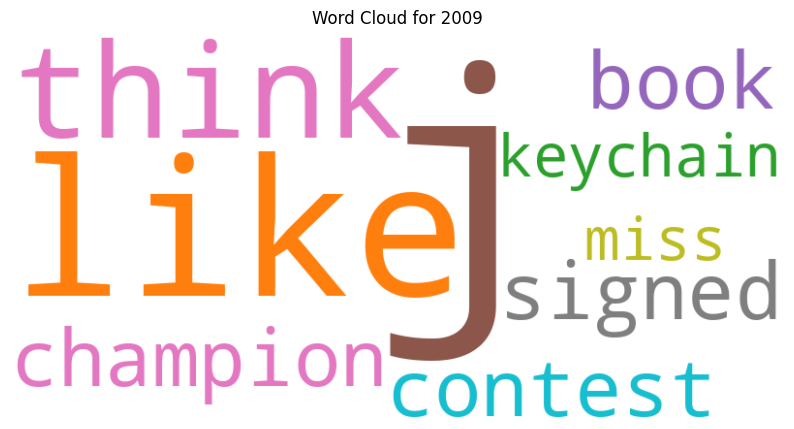

Word Cloud for 2010


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2010')

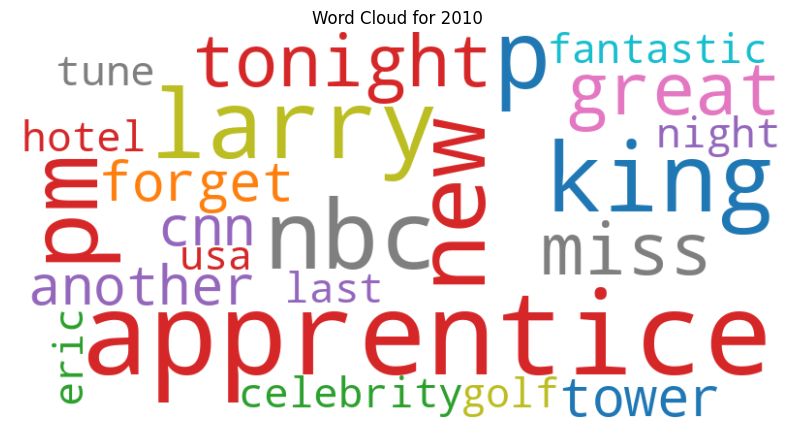

Word Cloud for 2011


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2011')

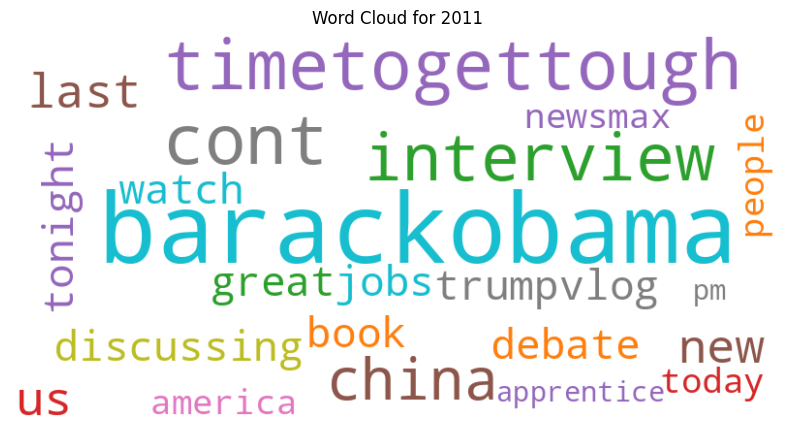

Word Cloud for 2012


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2012')

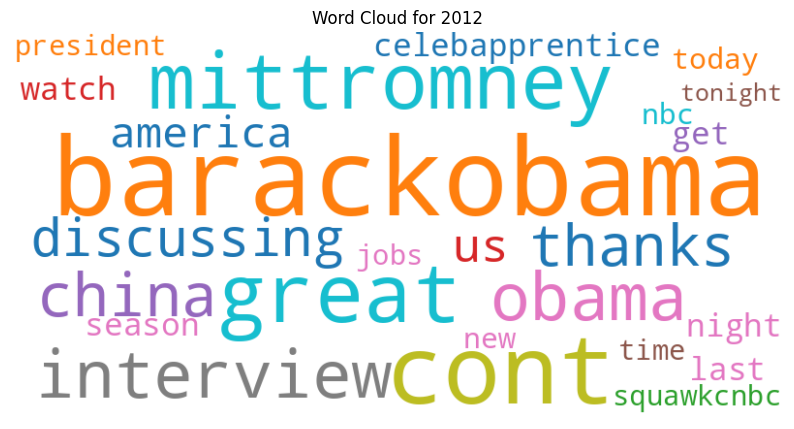

Word Cloud for 2013


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2013')

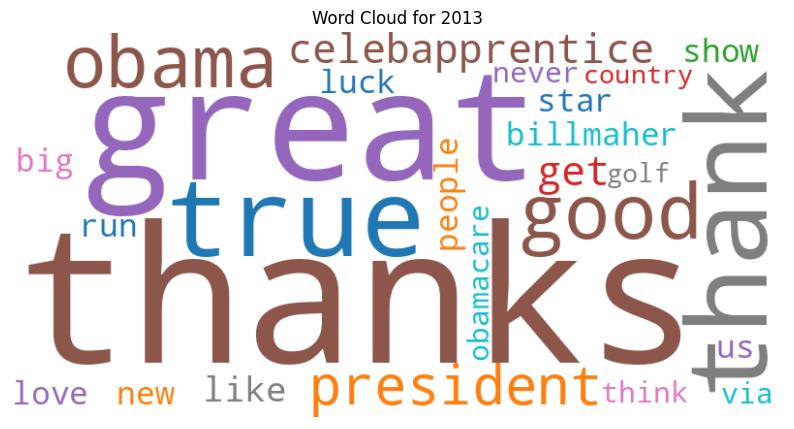

Word Cloud for 2014


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2014')

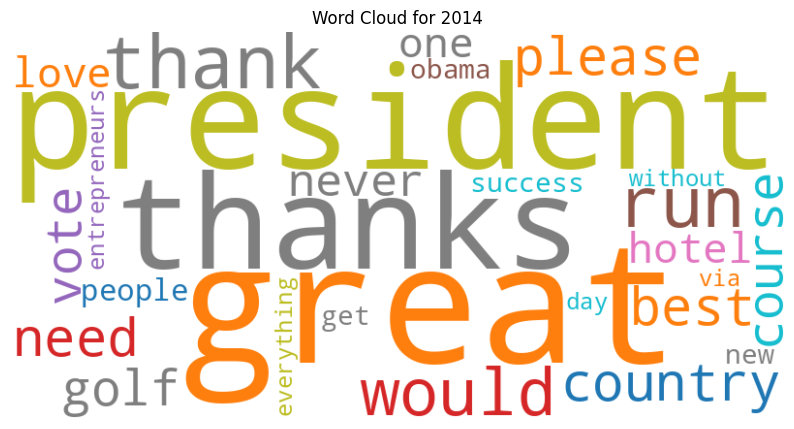

Word Cloud for 2015


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2015')

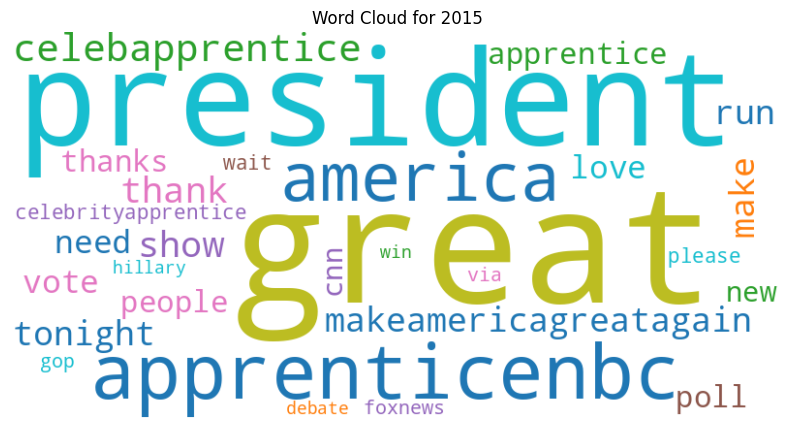

Word Cloud for 2016


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2016')

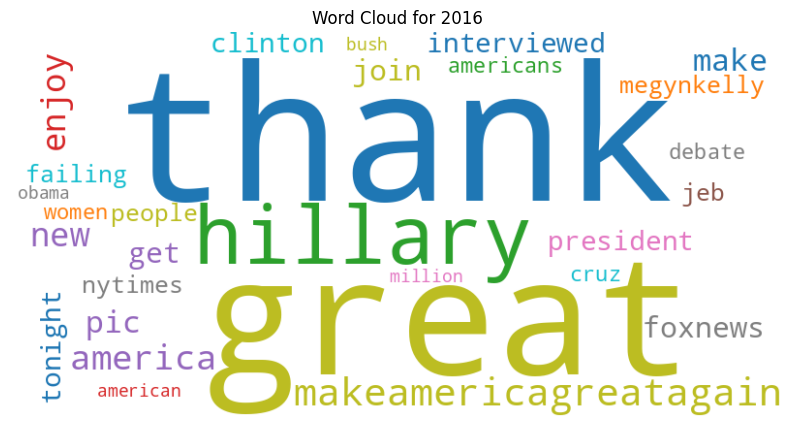

Word Cloud for 2017


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2017')

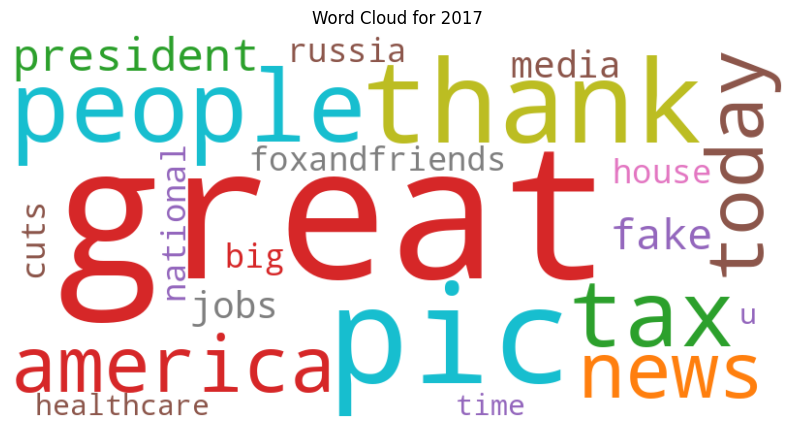

Word Cloud for 2018


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2018')

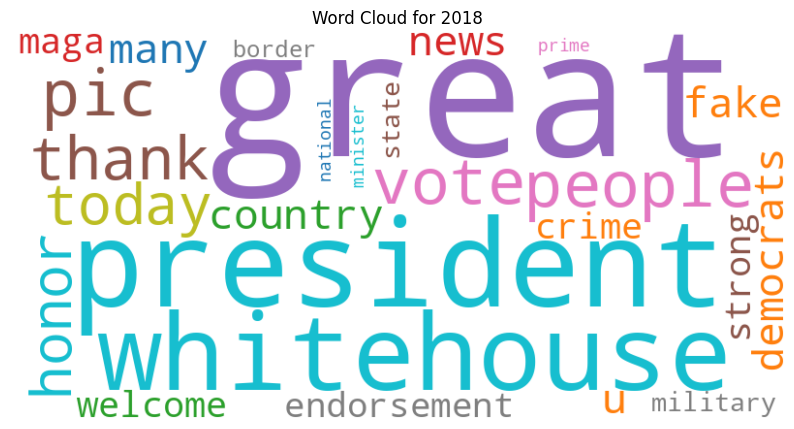

Word Cloud for 2019


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2019')

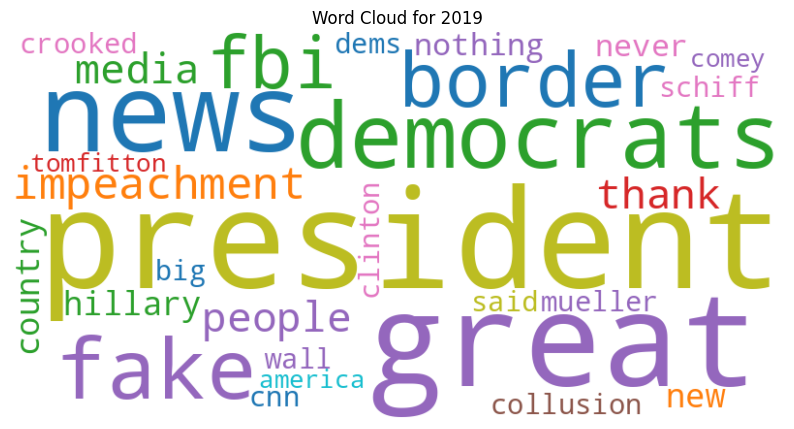

Word Cloud for 2020


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2020')

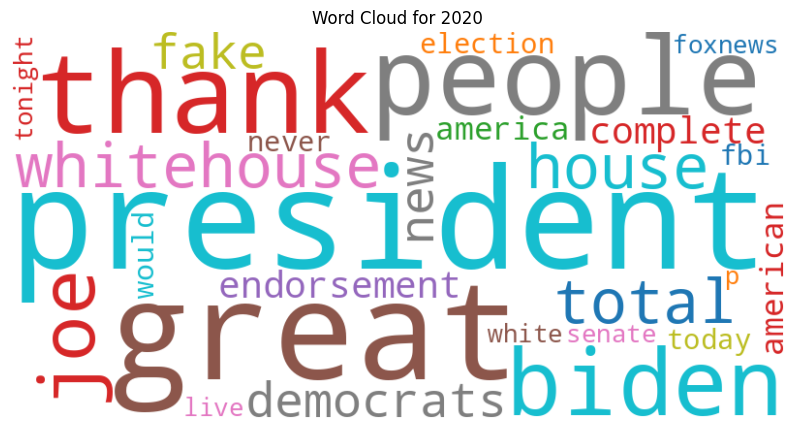

Word Cloud for 2021


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2021')

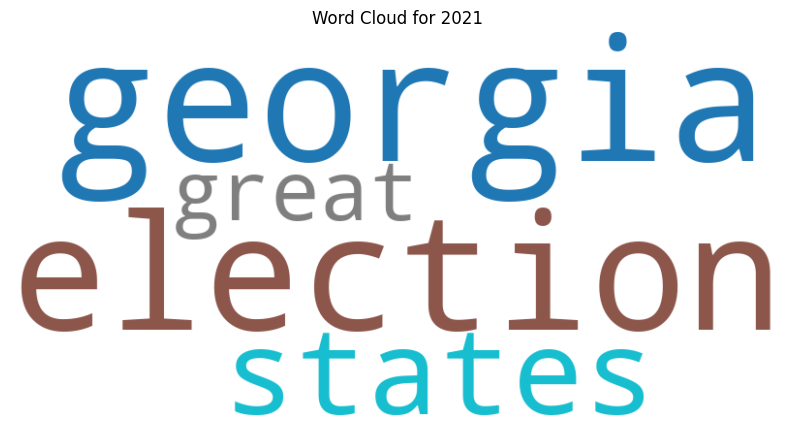

In [47]:

# Generate a word cloud for each year (combined topics, color-coded by topic)
for period, model in lda_models.items():
    print(f"Word Cloud for {period}")

    # Prepare the word frequencies and assign color based on topic
    word_frequencies = {}
    topic_colors = []  # List to store color assignments

    for topic_id, topic in model.print_topics(num_words=10):
        words = [word.split('*')[1].replace('"', '').strip() for word in topic.split(' + ')]
        topic_word_frequencies = {words[i]: float(topic.split(' + ')[i].split('*')[0]) for i in range(len(words))}

        # Add the words and frequencies to the overall dictionary
        for word, freq in topic_word_frequencies.items():
            if word in word_frequencies:
                word_frequencies[word] += freq
            else:
                word_frequencies[word] = freq

            # Color by topic id (0, 1, 2)
            topic_colors.append(topic_id)

    # Generate the word cloud from the frequencies
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap='tab10'
    ).generate_from_frequencies(word_frequencies)

    # Create the plot for the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {period}")

    # Display the word cloud
    plt.show()


Word Cloud for 2009


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2009')

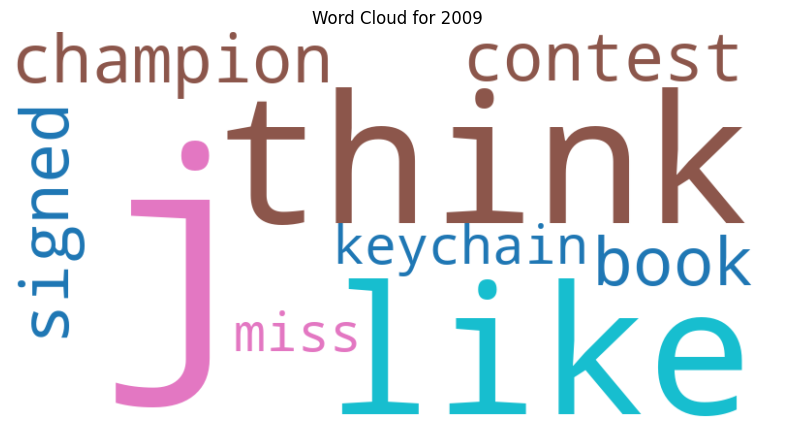

Saved word cloud for 2009 to wordclouds/wordcloud_2009.png
Word Cloud for 2010


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2010')

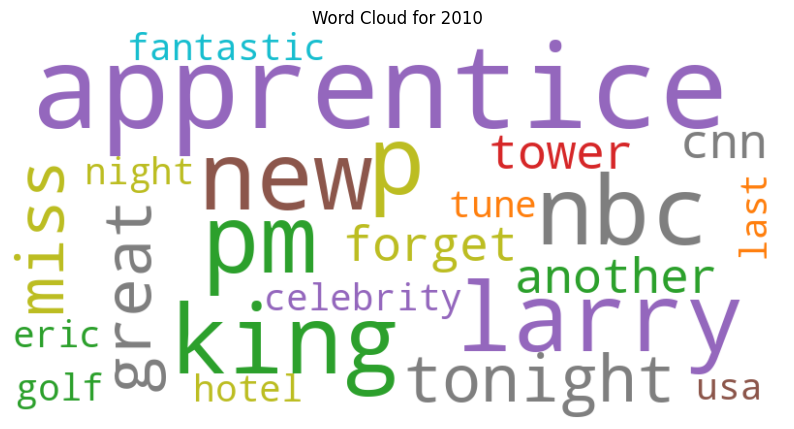

Saved word cloud for 2010 to wordclouds/wordcloud_2010.png
Word Cloud for 2011


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2011')

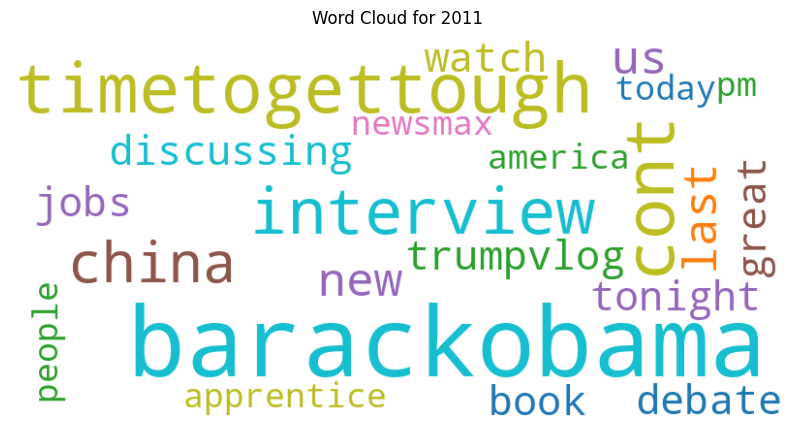

Saved word cloud for 2011 to wordclouds/wordcloud_2011.png
Word Cloud for 2012


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2012')

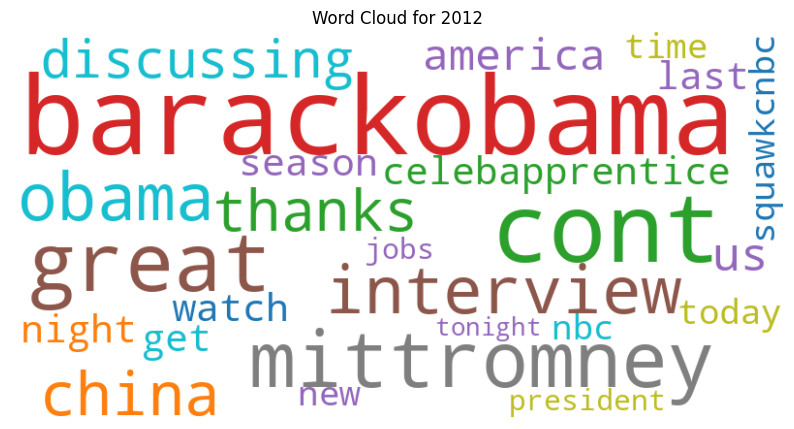

Saved word cloud for 2012 to wordclouds/wordcloud_2012.png
Word Cloud for 2013


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2013')

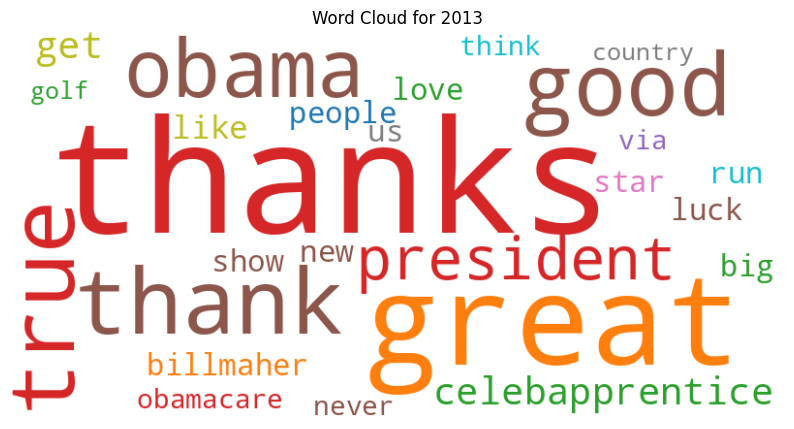

Saved word cloud for 2013 to wordclouds/wordcloud_2013.png
Word Cloud for 2014


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2014')

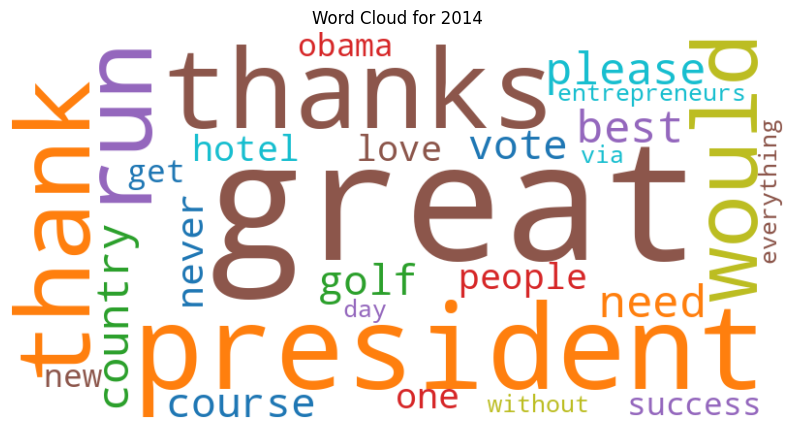

Saved word cloud for 2014 to wordclouds/wordcloud_2014.png
Word Cloud for 2015


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2015')

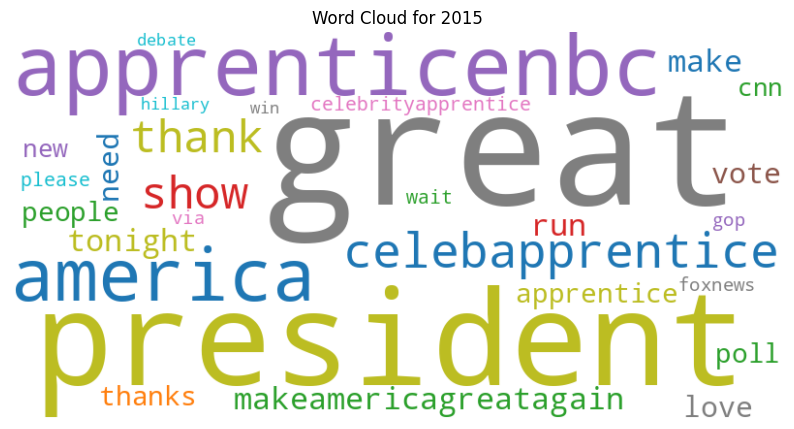

Saved word cloud for 2015 to wordclouds/wordcloud_2015.png
Word Cloud for 2016


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2016')

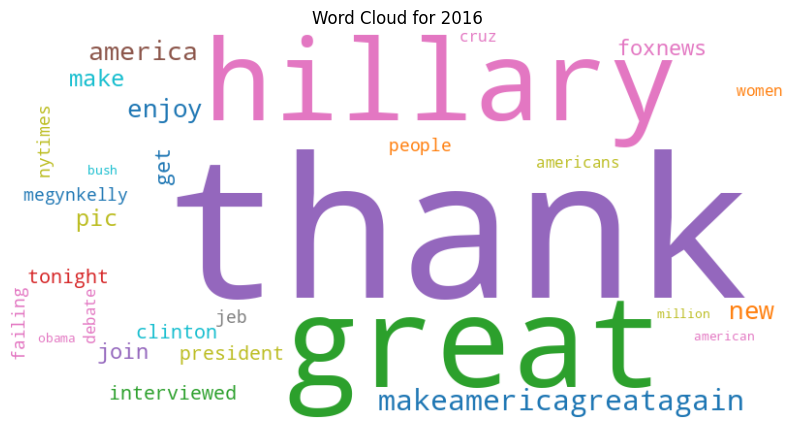

Saved word cloud for 2016 to wordclouds/wordcloud_2016.png
Word Cloud for 2017


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2017')

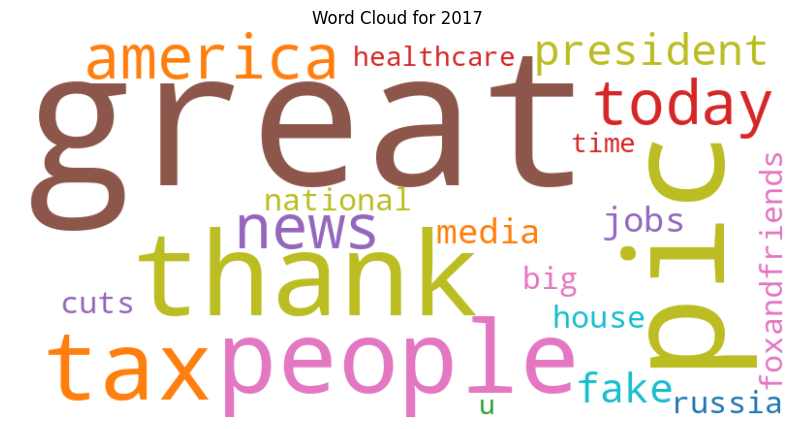

Saved word cloud for 2017 to wordclouds/wordcloud_2017.png
Word Cloud for 2018


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2018')

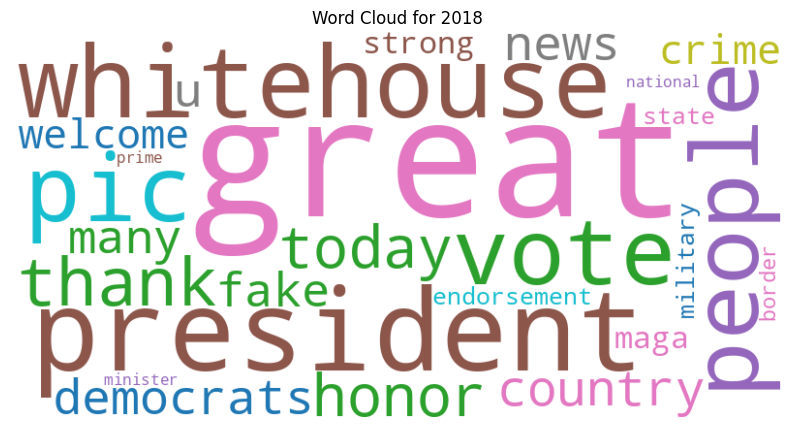

Saved word cloud for 2018 to wordclouds/wordcloud_2018.png
Word Cloud for 2019


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2019')

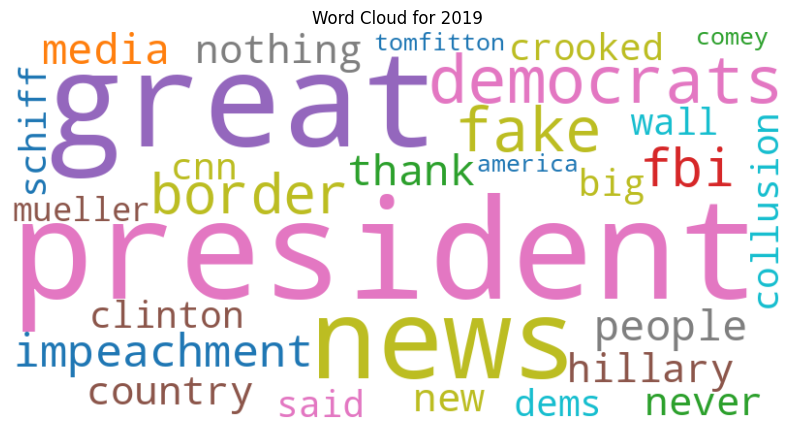

Saved word cloud for 2019 to wordclouds/wordcloud_2019.png
Word Cloud for 2020


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2020')

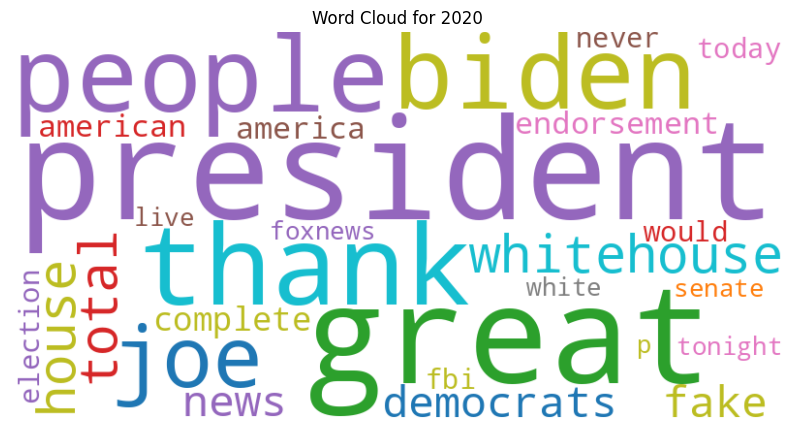

Saved word cloud for 2020 to wordclouds/wordcloud_2020.png
Word Cloud for 2021


<Figure size 1000x700 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for 2021')

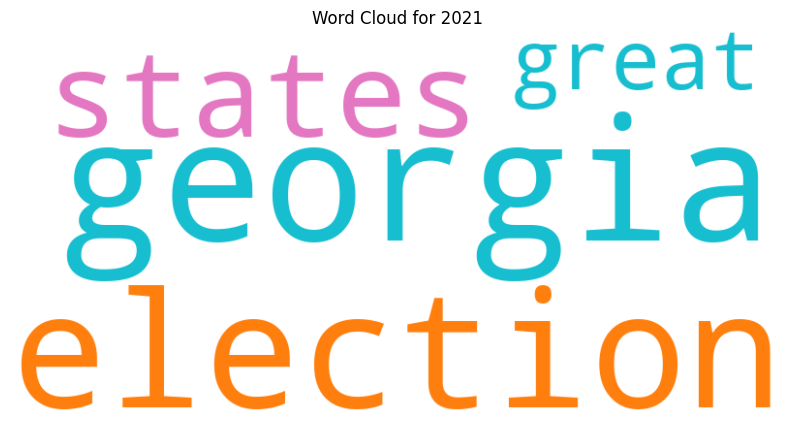

Saved word cloud for 2021 to wordclouds/wordcloud_2021.png


In [48]:

# Create a directory to save the images if it doesn't exist
output_dir = "wordclouds"
os.makedirs(output_dir, exist_ok=True)

# Generate a word cloud for each year (combined topics, color-coded by topic)
for period, model in lda_models.items():
    print(f"Word Cloud for {period}")

    # Prepare the word frequencies and assign color based on topic
    word_frequencies = {}
    topic_colors = []  # List to store color assignments

    for topic_id, topic in model.print_topics(num_words=10):
        words = [word.split('*')[1].replace('"', '').strip() for word in topic.split(' + ')]
        topic_word_frequencies = {words[i]: float(topic.split(' + ')[i].split('*')[0]) for i in range(len(words))}

        # Add the words and frequencies to the overall dictionary
        for word, freq in topic_word_frequencies.items():
            if word in word_frequencies:
                word_frequencies[word] += freq
            else:
                word_frequencies[word] = freq

            # Color by topic id (0, 1, 2)
            topic_colors.append(topic_id)

    # Generate the word cloud from the frequencies
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap='tab10'
    ).generate_from_frequencies(word_frequencies)

    # Create the plot for the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {period}")

    # Save the word cloud image to a file
    output_path = os.path.join(output_dir, f"wordcloud_{period}.png")
    plt.savefig(output_path, bbox_inches='tight')

    # Optionally, show the word cloud
    plt.show()

    print(f"Saved word cloud for {period} to {output_path}")


## Load Event Data

In [55]:
trump_events_df = pd.read_csv("/content/drive/MyDrive/QSS_45/trump_events_cleaned.csv")

## Clean Event Data

In [56]:
# Define a custom function to clean tweets
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove specific words
    custom_stopwords = ["trump", "twitter", "https", "donald", "com", "realdonaldtrump", "amp", "rt"]
    all_stopwords = set(stopwords.words("english")).union(custom_stopwords)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in all_stopwords])
    return text

nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

def preprocess_text(text, method='lemmatize'):
    # Process the text using spaCy
    doc = nlp(text)
    if method == 'lemmatize':
        # Lemmatization: Remove stopwords and lemmatize the words
        return " ".join([token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS])
    elif method == 'stem':
        # Stemming: Remove stopwords and stem the words
        return " ".join([stemmer.stem(token.text) for token in doc if token.text not in STOP_WORDS])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [57]:
trump_events_df['event'] = trump_events_df['event'].apply(clean_text)

trump_events_df['event'] = trump_events_df['event'].apply(preprocess_text)

In [58]:
trump_events_df['date'] = pd.to_datetime(trump_events_df['date'], errors='coerce')


# Method 1: LDA, Logistic Model, Matching Topics

### LDA Events Data

In [59]:
# Vectorize the events text
vectorizer = CountVectorizer(max_df=0.9,
                             min_df=5,
                             stop_words='english')
X = vectorizer.fit_transform(trump_events_df['event'])

# Apply LDA to find topics
#lda = LatentDirichletAllocation(n_components=7, random_state=42)
lda = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', random_state=42)
lda.fit(X)

# Get the topic distributions for each tweet
topics = lda.transform(X)

# Add the dominant topic to the DataFrame
trump_events_df['dominant_topic'] = topics.argmax(axis=1)

# Group by time period and count topic occurrences
trump_events_df['month'] = trump_events_df['date'].dt.to_period('M')
topic_counts = trump_events_df.groupby(['month', 'dominant_topic']).size().unstack(fill_value=0)

def get_topic_labels(model, feature_names, num_top_words=5):
    topic_labels = []
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        label = f"Topic {idx + 1}: " + " ".join(top_words)
        topic_labels.append(label)
    return topic_labels

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()
topic_labels = get_topic_labels(lda, feature_names)


LatentDirichletAllocation(learning_method='online', random_state=42)

In [60]:

# Create a dictionary with topic numbers and their corresponding labels
topics_dict = {
    1: "COVID-19 Response and Health Agreements",
    2: "Impeachment and Congressional Press Statements",
    3: "National Unity and Public Statements",
    4: "Election Campaigns and Federal House Proceedings",
    5: "2020 Election and Biden's Presidential Campaign",
    6: "State Executive Orders and Policy Announcements",
    7: "Presidential Debates and Attorney General Discussions",
    8: "Supreme Court Orders and Presidential Bans",
    9: "Border and Immigration Policy Statements",
    10: "North Korea Summit and Presidential Tweets"
}

# Apply the dictionary to create a new column 'topic'
trump_events_df['topic_label'] = trump_events_df['dominant_topic'].map(topics_dict)


### Topic Designation for Tweets Data

In [62]:
# Step 1: Train the model on LDA-tagged events dataset
X_events = trump_events_df['event']  # Event descriptions
y_events = trump_events_df['dominant_topic']  # LDA tags

# Split into training and test sets (you can also skip the test set for simplicity)
X_train, X_test, y_train, y_test = train_test_split(X_events, y_events, test_size=0.3, random_state=42)

# Use TfidfVectorizer to convert the event descriptions into numerical features
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict the topics for the test data (you can also evaluate this step)
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
print("Event Topic Classification Report:")
print(classification_report(y_test, y_pred))

LogisticRegression(max_iter=1000)

Event Topic Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.20      0.33         5
           2       0.50      0.50      0.50         8
           3       0.24      1.00      0.38         8
           4       0.00      0.00      0.00         0
           5       0.38      0.38      0.38         8
           6       0.00      0.00      0.00         3
           7       1.00      0.36      0.53        11
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         2

    accuracy                           0.36        56
   macro avg       0.31      0.24      0.21        56
weighted avg       0.44      0.36      0.31        56



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [63]:
# Fill NaN values in 'cleaned_content' with an empty string
trump_all_df['cleaned_content'] = trump_all_df['cleaned_content'].fillna('')

# Convert the data to tf-idf features
tweets_tfidf = vectorizer.transform(trump_all_df['cleaned_content'])

# Predict the topics for tweets
trump_all_df['predicted_topic'] = clf.predict(tweets_tfidf)


In [65]:


# Apply the dictionary to create a new column 'topic'
trump_all_df['topic_label'] = trump_all_df['predicted_topic'].map(topics_dict)


### Subset Data to Match Timeframes

In [69]:
trump_all_df['date'] = pd.to_datetime(trump_all_df['date'])

# Filter the DataFrame for the desired date range
trump_all_df_date = trump_all_df[(trump_all_df['date'] >= '2016-07-19') & (trump_all_df['date'] <= '2024-07-15')]

trump_events_df_date = trump_events_df[(trump_events_df['date'] <= '2021-01-08')]

trump_events_df_date['date'] = pd.to_datetime(trump_events_df_date['date'])


<ipython-input-69-1f5d58be0cff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_events_df_date['date'] = pd.to_datetime(trump_events_df_date['date'])


### Cross Analysis between Tweet-Event Matches & Approval Data

In [70]:
# Create an empty 'tweet_match' column in the events dataframe
trump_events_df_date['tweet_match'] = 'No'

# Loop over each event
for i, event in trump_events_df_date.iterrows():
    event_date = event['date']
    event_topic = event['dominant_topic']

    # Filter tweets within ±4 days of the event date
    time_window = pd.Timedelta(days=2)
    tweets_in_window = trump_all_df_date[(trump_all_df_date['date'] >= event_date - time_window) &
                                  (trump_all_df_date['date'] <= event_date + time_window)]

    # Check if there is a tweet with the same topic as the event within the time window
    if any(tweets_in_window['predicted_topic'] == event_topic):
        trump_events_df_date.at[i, 'tweet_match'] = 'Yes'  # Mark 'Yes' if match is found



<ipython-input-70-2dba0085a1ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_events_df_date['tweet_match'] = 'No'


In [71]:
# Create an empty 'event_match' column in the tweets dataframe
trump_all_df_date['event_match_before_after'] = 'No'

# Loop over each tweet
for i, tweet in trump_all_df_date.iterrows():
    tweet_date = tweet['date']
    tweet_topic = tweet['predicted_topic']

    # Filter events within ±2 days of the tweet date
    time_window = pd.Timedelta(days=2)
    events_in_window = trump_events_df_date[(trump_events_df_date['date'] >= tweet_date - time_window) &
                                            (trump_events_df_date['date'] <= tweet_date + time_window)]

    # Check if there is an event with the same topic as the tweet within the time window
    if any(events_in_window['dominant_topic'] == tweet_topic):
        trump_all_df_date.at[i, 'event_match_before_after'] = 'Yes'  # Mark 'Yes' if match is found



<ipython-input-71-94c44cc38745>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_all_df_date['event_match_before_after'] = 'No'


In [74]:
# Load data

approval_df = pd.read_csv("/content/drive/MyDrive/QSS_45/adj_approval_rates_df.csv")

In [79]:
trump_events_df_date['date'] = pd.to_datetime(trump_events_df_date['date'])
approval_df['startdate'] = pd.to_datetime(approval_df['startdate'])

<ipython-input-79-613ac8d998b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_events_df_date['date'] = pd.to_datetime(trump_events_df_date['date'])


T-statistic: -1.6343872683760947
P-value: 0.10418112862751762


{'whiskers': [<matplotlib.lines.Line2D at 0x7bdf581135b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7bdf581108e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bdf58112b30>,
 'medians': [<matplotlib.lines.Line2D at 0x7bdf58112bf0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7bdf58113760>,
 'means': []}

Text(0.5, 1.0, 'Approval Changes Around Events')

Text(0, 0.5, 'Approval Change (%)')

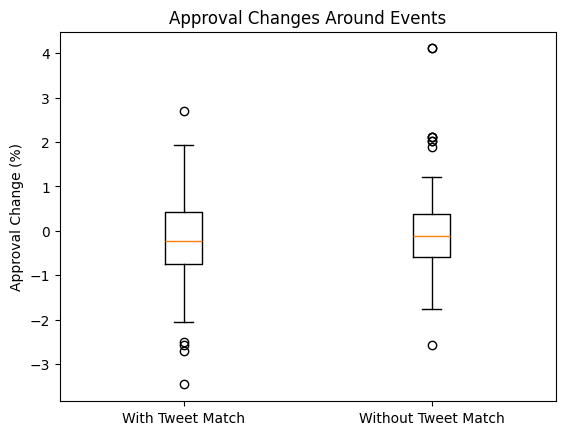

There is no statistically significant difference in approval changes between events with and without tweet matches.


In [85]:
# Define time windows
window_days = 10

# Preallocate lists for storing approval changes
approval_changes_with_match = []
approval_changes_without_match = []

# Loop through events
for _, event in trump_events_df_date.iterrows():
    event_date = event['date']
    tweet_match = event['tweet_match']  # 'Yes' or 'No'

    # Filter approval ratings for the pre-event and post-event windows
    pre_event = approval_df[
        (approval_df['startdate'] >= event_date - pd.Timedelta(days=window_days)) &
        (approval_df['startdate'] < event_date)
    ]['approve'].mean()

    post_event = approval_df[
        (approval_df['startdate'] > event_date) &
        (approval_df['startdate'] <= event_date + pd.Timedelta(days=window_days))
    ]['approve'].mean()

    # Calculate approval change
    approval_change = post_event - pre_event

    # Append to appropriate group
    if tweet_match == 'Yes':
        approval_changes_with_match.append(approval_change)
    else:
        approval_changes_without_match.append(approval_change)

# Remove NaNs from approval change lists
approval_changes_with_match = [x for x in approval_changes_with_match if pd.notna(x)]
approval_changes_without_match = [x for x in approval_changes_without_match if pd.notna(x)]

# Perform a t-test to compare the two groups
t_stat, p_val = ttest_ind(approval_changes_with_match, approval_changes_without_match, nan_policy='omit')

# Print t-test results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

# Create Box Plot
data = [approval_changes_with_match, approval_changes_without_match]

plt.boxplot(data, labels=['With Tweet Match', 'Without Tweet Match'])
plt.title('Approval Changes Around Events')
plt.ylabel('Approval Change (%)')
plt.show()

# Interpretation
if p_val < 0.05:
    print("There is a statistically significant difference in approval changes between events with and without tweet matches.")
else:
    print("There is no statistically significant difference in approval changes between events with and without tweet matches.")
